# 이진 분류

시그모이드 함수

In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn

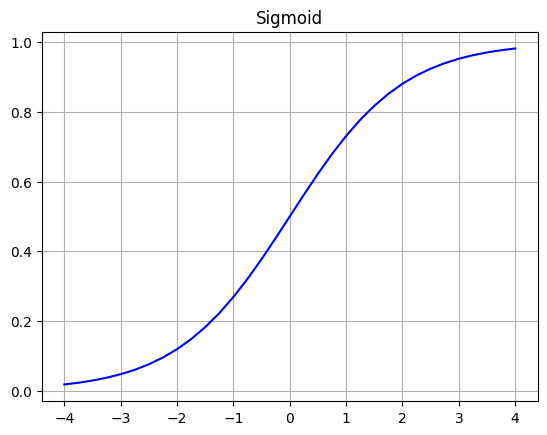

In [2]:
x_np = np.arange(-4, 4.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.sigmoid(x)

plt.title('Sigmoid')
plt.plot(x, y, c='b')
plt.grid()
plt.show()

데이터 준비

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()

#입력 데이터와 정답 데이터
x_org, y_org = iris.data, iris.target

print(x_org.shape, y_org.shape)

(150, 4) (150,)


In [4]:
#데이터 추출
#클래스는 0 or 1
#항목은 sepal_length, sepal_width

x_data = iris.data[:100, :2]
y_data = iris.target[:100]

print('대상 데이터: ', x_data.shape, y_data.shape)

대상 데이터:  (100, 2) (100,)


In [5]:
#데이터 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    train_size=70, test_size=30,
                                                    random_state=123)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70, 2) (30, 2) (70,) (30,)


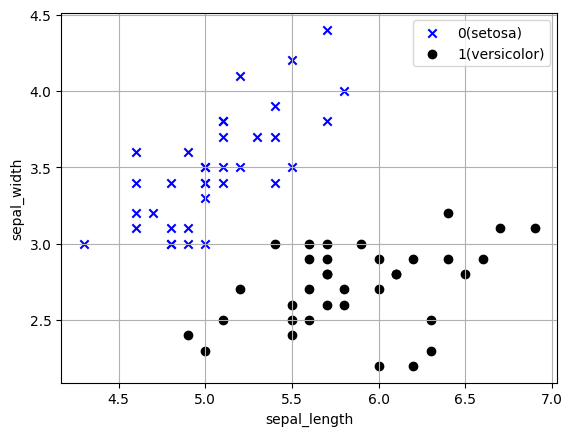

In [6]:
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker='x', c= 'b', label ='0(setosa)')
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker='o', c='k', label = '1(versicolor)')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.grid()
plt.legend()
plt.show()

In [7]:
n_input = x_train.shape[1]

n_output = 1

print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 1


In [8]:
#모델 정의
#2입력 1출력 로지스틱 회귀모델
class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = nn.Sigmoid()

        #초기값 모두 1(책과 결과 맞추려고)
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        #선형 함수에 입력값을 넣고 계산한 결과
        x1 = self.l1(x)
        
        #결과를 시그모이드 함수에 적용
        x2 = self.sigmoid(x1)

        return x2

In [9]:
from torchinfo import summary
net = Net(n_input, n_output)

print(net)
summary(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Layer (type:depth-idx)                   Param #
Net                                      --
├─Linear: 1-1                            3
├─Sigmoid: 1-2                           --
Total params: 3
Trainable params: 3
Non-trainable params: 0

In [10]:
#최적화 알고리즘과 손실 함수의 정의
criterion = nn.BCELoss()#손실함수: 교차 엔트로피 함수

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

In [11]:
#BCELoss: 두 번째 인수로 들어갈 정답 데이터는 첫 번째 인수(훈련데이터)와 그 shape이 같아야함
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()

#정답 데이터는 (N, 1)행렬로 변환
labels1 = labels.view((-1, 1))

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()

labels1_test = labels_test.view((-1, 1))

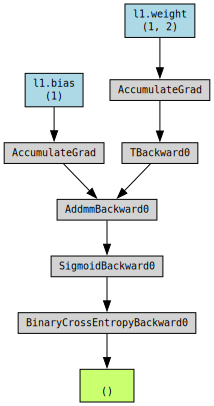

In [12]:
from torchviz import make_dot

#손실 계산 그래프 출력
outputs = net(inputs)

loss = criterion(outputs, labels1)

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

초기화 처리

In [13]:
lr = 0.01

net = Net(n_input, n_output)

criterion = nn.BCELoss()

num_epoch = 10000

optimizer = optim.SGD(net.parameters(), lr=lr)

history = np.zeros((0, 5))#5열: 1(반복횟수) 2(훈련데이터손실값) 3(훈련정확도) 4(검증데이터 손실값) 5(검증 정확도)

In [14]:
for epoch in range(num_epoch):
    #훈련#
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, labels1)

    loss.backward()

    optimizer.step()

    #손실 저장(스칼라 값 취득
    train_loss = loss.item()

    #예측 라벨(1or0) 계산
    predicted = torch.where(outputs < 0.5, 0, 1) #모델 출력의 확률 값을 0.5와 비교해서 예측 값이 1인지 또는 0인지 판단

    #정확도 계산
    train_acc = (predicted == labels1).sum() / len(y_train)
    #훈련#


    #예측#
    outputs_test = net(inputs_test)

    loss_test = criterion(outputs_test, labels1_test)

    val_loss = loss_test.item()

    predicted_test = torch.where(outputs_test < 0.5, 0, 1)

    val_acc = (predicted_test == labels1_test).sum() / len(y_test)

    if (epoch % 10 == 0):
        print(f'Epoch: [{epoch} / {num_epoch}] loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f} val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))
    #예측#

Epoch: [0 / 10000] loss: 4.77289 acc: 0.50000 val_loss: 4.49384 val_acc: 0.50000
Epoch: [10 / 10000] loss: 3.80546 acc: 0.50000 val_loss: 3.56537 val_acc: 0.50000
Epoch: [20 / 10000] loss: 2.84328 acc: 0.50000 val_loss: 2.64328 val_acc: 0.50000
Epoch: [30 / 10000] loss: 1.91613 acc: 0.50000 val_loss: 1.76244 val_acc: 0.50000
Epoch: [40 / 10000] loss: 1.17137 acc: 0.50000 val_loss: 1.08537 val_acc: 0.50000
Epoch: [50 / 10000] loss: 0.84140 acc: 0.50000 val_loss: 0.81872 val_acc: 0.50000
Epoch: [60 / 10000] loss: 0.77087 acc: 0.50000 val_loss: 0.77093 val_acc: 0.50000
Epoch: [70 / 10000] loss: 0.75450 acc: 0.34286 val_loss: 0.76105 val_acc: 0.33333
Epoch: [80 / 10000] loss: 0.74542 acc: 0.25714 val_loss: 0.75447 val_acc: 0.20000
Epoch: [90 / 10000] loss: 0.73734 acc: 0.24286 val_loss: 0.74778 val_acc: 0.16667
Epoch: [100 / 10000] loss: 0.72949 acc: 0.24286 val_loss: 0.74098 val_acc: 0.13333
Epoch: [110 / 10000] loss: 0.72180 acc: 0.27143 val_loss: 0.73419 val_acc: 0.16667
Epoch: [120 / 1

In [15]:
print(f'초기상태: 손실:{history[0, 1]}   정확도:{history[0, 2]}')
print(f'최종상태: 손실:{history[-1, 1]}   정확도:{history[-1, 2]}')

초기상태: 손실:4.772893905639648   정확도:0.5
최종상태: 손실:0.07955486327409744   정확도:1.0


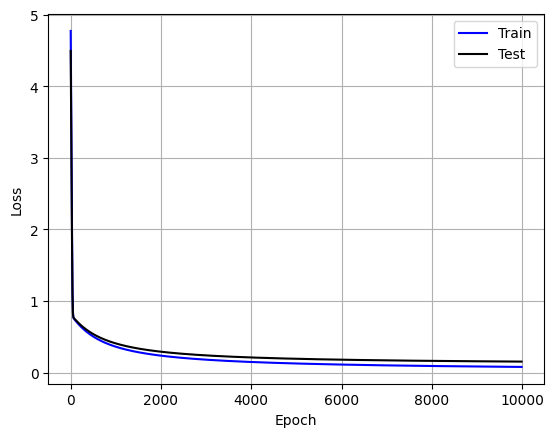

In [18]:
#학습곡선(손실)
plt.plot(history[:, 0], history[:, 1], c = 'b', label='Train')
plt.plot(history[:, 0], history[:, 3], c='k', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

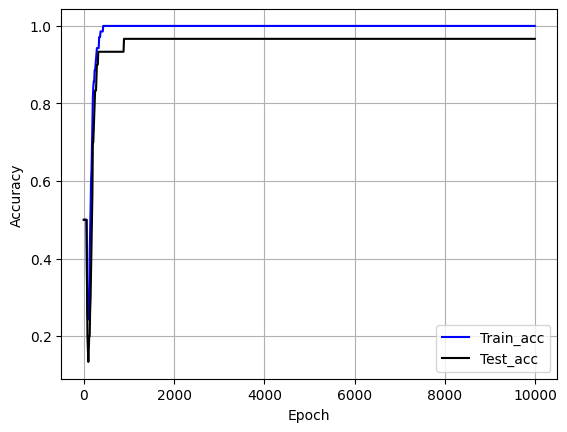

In [19]:
plt.plot(history[:, 0], history[:, 2], c='b', label='Train_acc')
plt.plot(history[:, 0], history[:, 4], c='k', label ='Test_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

결정 경계의 선형 방정식
* $sigmoid(w_0	 ⋅x_0​	 +w_1 ⋅x_1 +b)=0.5$

직선의 방정식에 따라
* $ w_0	 ⋅x_0​	 +w_1 ⋅x_1 +b = 0 $

직선의 방정식으로부터 x1 계산
* $x_1$ = −$w_1 \over{w_0}$ $⋅x_0$ − $w_1 \over{b}$
​	
 

In [31]:
# 결정 경계 그리기
w0, w1 = net.l1.weight[0] #net.l1.weight, 즉 가중치를 가져옴
b = net.l1.bias[0] #net.l1.bias, 즉 바이어스를 가져옴(b)
x1_min, x1_max = x_train[:, 0].min(), x_train[:, 0].max() #x_train[:, 0](sepal_length)의 특성을 가져옴, min, max --> 결정 경계를 그릴 때 필요한 x1의 범위를 설정하는 데 사용
x2_min, x2_max = x_train[:, 1].min(), x_train[:, 1].max() #x_train[:, 1](sepal_width)의 특성을 가져옴, min, max --> 결정 경계를 그릴 때 필요한 x1의 범위를 설정하는 데 사용
x1_range = np.linspace(x1_min, x1_max, 200) #x1_min에서 x1_max까지 200개의 균일한 값을 생성, 이는 결정 경계를 매끄럽게 그리기 위해 사용
x2_range = -(w0.item() * x1_range + b.item()) / w1.item()

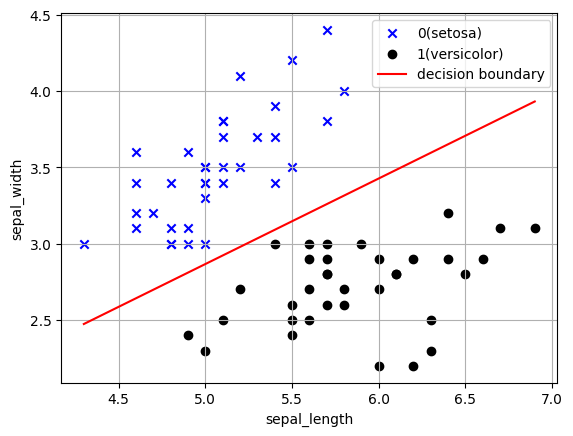

In [32]:
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker='x', c= 'b', label ='0(setosa)')
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker='o', c='k', label = '1(versicolor)')
plt.plot(x1_range, x2_range, 'r-', label='decision boundary')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.grid()
plt.legend()
plt.show()